In [1]:
# Khởi tạo Spark Session
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder \
    .appName("BookRecommendationSystem") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "10") \
    .config("spark.default.parallelism", "10") \
    .getOrCreate()

# Hiển thị thông tin phiên bản Spark
print(f"Spark version: {spark.version}")

# Tải dữ liệu từ HDFS

# Đường dẫn đến dữ liệu trên HDFS
books_file = "hdfs://namenode:9000/user/hadoop/book_recommendation/books_data.csv"
ratings_file = "hdfs://namenode:9000/user/hadoop/book_recommendation/Books_rating.csv"

book_rating = spark.read.csv(
    ratings_file,
    header=True,
    inferSchema=True
)

book_data = spark.read.csv(
    books_file,
    header=True,
    inferSchema=True
)

# Đổi tên cột và ép kiểu dữ liệu
ratings = book_rating.select(
    col("User_id").alias("UserID"),
    col("Id").alias("BookID"),
    col("title"),
    col("review/score").cast("float").alias("Rating")
).na.drop()

books = book_data.select("title", "categories").na.drop()

# # Đọc dữ liệu
# try:
#     books_df = spark.read.csv(books_file, header=True, inferSchema=True)
#     ratings_df = spark.read.csv(ratings_file, header=True, inferSchema=True)
#     print("Đã tải dữ liệu từ HDFS thành công!")
# except Exception as e:
#     print(f"Lỗi khi tải dữ liệu từ HDFS: {str(e)}")
#     # Dự phòng: Tải từ local nếu HDFS không hoạt động
#     books_df = spark.read.csv("/path/to/local/books_data.csv", header=True, inferSchema=True)
#     ratings_df = spark.read.csv("/path/to/local/Books_rating.csv", header=True, inferSchema=True)

Spark version: 3.5.0


In [3]:
from pyspark.sql.types import FloatType, StringType
from pyspark.ml.feature import StringIndexer

# **3️⃣ Xử lý dữ liệu từ book_data.csv**
books = book_data.select(
    col("title"),
    col("categories")
).na.drop()

# **4️⃣ Ghép hai bảng theo title**
ratings_with_categories = ratings.join(books, "title", "inner")

# **5️⃣ Áp dụng StringIndexer để chuyển đổi UserID & BookID thành số**
user_indexer = StringIndexer(inputCol="UserID", outputCol="UserIndex")
book_indexer = StringIndexer(inputCol="BookID", outputCol="BookIndex")

ratings_with_categories = user_indexer.fit(ratings_with_categories).transform(ratings_with_categories)
ratings_with_categories = book_indexer.fit(ratings_with_categories).transform(ratings_with_categories)

# **6️⃣ Bỏ giá trị null nếu có**
ratings_with_categories = ratings_with_categories.na.drop()

# **7️⃣ Kiểm tra số lượng dòng có giá trị null trong các cột quan trọng**
null_counts = ratings_with_categories.select([
    (col(c).isNull()).cast("int").alias(c) for c in ratings_with_categories.columns
]).groupBy().sum()

null_counts.show()

# **8️⃣ Lọc người dùng và sách có số lượng đánh giá ít hơn ngưỡng (ví dụ: 5)**
min_reviews = 5

# Lọc người dùng có ít đánh giá
filtered_users = ratings_with_categories.groupBy("UserID").count().filter(f"count >= {min_reviews}")
valid_users = filtered_users.select("UserID")

# Lọc sách có ít đánh giá
filtered_books = ratings_with_categories.groupBy("BookID").count().filter(f"count >= {min_reviews}")
valid_books = filtered_books.select("BookID")

# Chỉ giữ lại những người dùng và sách hợp lệ
ratings_filtered = ratings_with_categories.join(valid_users, "UserID").join(valid_books, "BookID")

# **9️⃣ Lấy mẫu 20% của dữ liệu**
ratings_sampled = ratings_filtered.sample(fraction=1.0, seed=42)

ratings_sampled = ratings_sampled.withColumn("UserIndex", col("UserIndex").cast("int")) \
                                 .withColumn("BookIndex", col("BookIndex").cast("int")) \
                                 .withColumn("Rating", col("Rating").cast("float"))

# Kiểm tra kích thước và số phân vùng của dữ liệu mẫu
print(f"Total rows in sampled data: {ratings_sampled.count()}")
print(f"Total partitions in sampled data: {ratings_sampled.rdd.getNumPartitions()}")

# Hiển thị dữ liệu mẫu
ratings_sampled.show(5)

# **🔟 Đảm bảo rằng số phân vùng không quá nhỏ**
ratings_sampled = ratings_sampled.repartition(20)

# Hiển thị lại dữ liệu mẫu sau khi thay đổi số phân vùng
ratings_sampled.show(5)
(train_data, test_data) = ratings_sampled.randomSplit([0.8, 0.2], seed=42)

+----------+-----------+-----------+-----------+---------------+--------------+--------------+
|sum(title)|sum(UserID)|sum(BookID)|sum(Rating)|sum(categories)|sum(UserIndex)|sum(BookIndex)|
+----------+-----------+-----------+-----------+---------------+--------------+--------------+
|         0|          0|          0|          0|              0|             0|             0|
+----------+-----------+-----------+-----------+---------------+--------------+--------------+

Total rows in sampled data: 806462
Total partitions in sampled data: 10
+----------+--------------+--------------------+------+--------------------+---------+---------+
|    BookID|        UserID|               title|Rating|          categories|UserIndex|BookIndex|
+----------+--------------+--------------------+------+--------------------+---------+---------+
|0262560992|A101E76MMGBIDY|The Little Scheme...|   5.0|['Daniel P. Fried...|    18785|     7076|
|B0006DH7WU|A101E76MMGBIDY|           CRANFORD.|   5.0|         

In [4]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, desc, count

# Đếm số lượng đánh giá của từng thể loại theo người dùng
user_top_genres = ratings_sampled.groupBy("UserID", "categories") \
    .agg(count("Rating").alias("num_ratings")) \
    .orderBy("UserID", desc("num_ratings"))

# Tạo cột xếp hạng trong mỗi nhóm UserID
window_spec = Window.partitionBy("UserID").orderBy(desc("num_ratings"))

user_top_genres = user_top_genres.withColumn("rank", row_number().over(window_spec))

# Lọc lấy top 10 thể loại mà mỗi người dùng hay rating nhất
user_top_genres = user_top_genres.filter(col("rank") <= 10).drop("rank")

user_top_genres.show(10)

+--------------------+--------------------+-----------+
|              UserID|          categories|num_ratings|
+--------------------+--------------------+-----------+
|A00891092QIVH4W1Y...|      ['Audiobooks']|          2|
|A00891092QIVH4W1Y...|['Boarding schools']|          1|
|A00891092QIVH4W1Y...|      ['Foundlings']|          1|
|A00891092QIVH4W1Y...|         ['Fiction']|          1|
|A02660181QI9HHAVF...|['Juvenile Fiction']|          7|
|A02660181QI9HHAVF...|['Adventure stori...|          1|
|A02660181QI9HHAVF...|         ['Fiction']|          1|
|A0431300QHCFN1LOVE1Z|['Juvenile Fiction']|          6|
|A0431300QHCFN1LOVE1Z|         ['Fiction']|          1|
|A0431300QHCFN1LOVE1Z|['Adventure stori...|          1|
+--------------------+--------------------+-----------+
only showing top 10 rows



In [5]:
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col, explode
from pyspark.ml.evaluation import RegressionEvaluator


# Train mô hình ALS
als = ALS(
    maxIter=20,
    regParam=0.1,
    userCol="UserIndex",
    itemCol="BookIndex",
    ratingCol="Rating",
    coldStartStrategy="drop"
)

model = als.fit(train_data)

hdfs_model_path = "hdfs://namenode:9000/user/hadoop/book_recommendation/models/als_model"

try:
    # Lưu mô hình
    model.write().overwrite().save(hdfs_model_path)
    print(f"Mô hình đã được lưu thành công tại: {hdfs_model_path}")
except Exception as e:
    print(f"Lỗi khi lưu mô hình: {str(e)}")
    
    # Nếu không thể lưu vào HDFS, thử lưu vào thư mục local
    try:
        local_model_path = "/home/jovyan/work/notebooks/als_model"
        model.write().overwrite().save(local_model_path)
        print(f"Mô hình đã được lưu thành công vào thư mục local: {local_model_path}")
    except Exception as e2:
        print(f"Lỗi khi lưu mô hình vào thư mục local: {str(e2)}")


predictions = model.transform(test_data)

# Hiển thị một số dòng dữ liệu dự đoán
predictions.select("UserIndex", "BookIndex", "Rating", "prediction").show(5)


# Tạo evaluator cho RMSE
rmse_evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="Rating",
    predictionCol="prediction"
)

# Tạo evaluator cho MAE
mae_evaluator = RegressionEvaluator(
    metricName="mae",
    labelCol="Rating",
    predictionCol="prediction"
)

# Tính toán lỗi
rmse = rmse_evaluator.evaluate(predictions)
mae = mae_evaluator.evaluate(predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
# Dự đoán 10 cuốn sách phù hợp nhất cho mỗi UserIndex
user_recommendations = model.recommendForAllUsers(10)

# Tách danh sách đề xuất thành từng dòng
user_recommendations = user_recommendations.withColumn("recommendations", explode(col("recommendations")))
user_recommendations = user_recommendations.select("UserIndex", col("recommendations.BookIndex").alias("BookIndex"))

# **Ghép với dữ liệu rating để lấy thông tin sách, giữ lại cả UserIndex**
recommendations_with_titles = user_recommendations.join(
    ratings_filtered.select("UserIndex", "BookIndex", "title", "categories").distinct(),
    ["UserIndex", "BookIndex"]
)

# Kiểm tra kết quả
recommendations_with_titles.show(5)

Mô hình đã được lưu thành công tại: hdfs://namenode:9000/user/hadoop/book_recommendation/models/als_model
+---------+---------+------+----------+
|UserIndex|BookIndex|Rating|prediction|
+---------+---------+------+----------+
|      586|    12868|   3.0|  3.343993|
|    26953|     1108|   5.0|  4.287701|
|     2821|     1108|   4.0|  4.634313|
|    41362|      130|   5.0| 4.8908486|
|    35012|      130|   5.0| 4.8891063|
+---------+---------+------+----------+
only showing top 5 rows

RMSE: 0.8372717016150891
MAE: 0.5243804319526931
+---------+---------+--------------------+--------------------+
|UserIndex|BookIndex|               title|          categories|
+---------+---------+--------------------+--------------------+
|      149|    58536|Penthouse Adult M...|['Business & Econ...|
|      423|    28928|Veto procedures (...|            ['Veto']|
|      423|    48941|      First Overland|      sixty years on|
|      448|    59285|Penthouse Adult M...|['Business & Econ...|
|      652| 

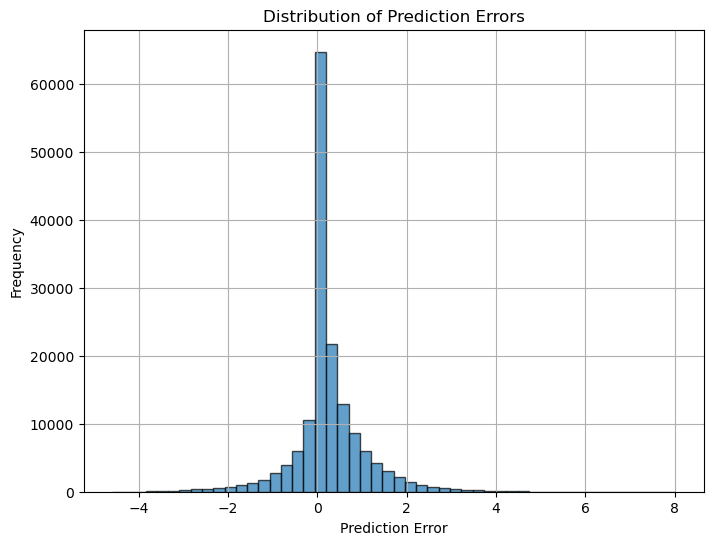

In [6]:
predictions_pd = predictions.select("Rating", "prediction").toPandas()

import matplotlib.pyplot as plt

# Tính toán sai số
predictions_pd["error"] = predictions_pd["Rating"] - predictions_pd["prediction"]

# Vẽ histogram của sai số
plt.figure(figsize=(8, 6))
plt.hist(predictions_pd["error"], bins=50, edgecolor="k", alpha=0.7)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.grid(True)
plt.show()

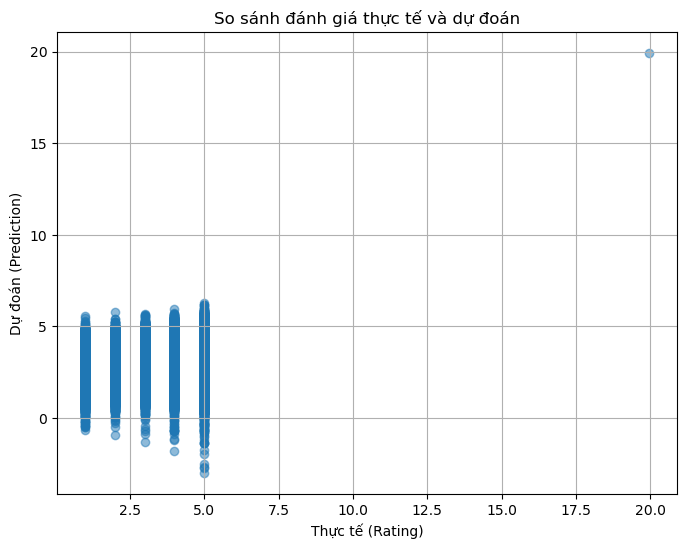

In [7]:
plt.figure(figsize=(8, 6))
plt.scatter(predictions_pd["Rating"], predictions_pd["prediction"], alpha=0.5)
plt.xlabel("Thực tế (Rating)")
plt.ylabel("Dự đoán (Prediction)")
plt.title("So sánh đánh giá thực tế và dự đoán")
plt.grid(True)
plt.show()

In [8]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, count, col, desc

# Tính số lượng đánh giá cho mỗi thể loại của người dùng
user_top_genres = ratings_filtered.groupBy("UserIndex", "categories") \
    .agg(count("Rating").alias("num_ratings"))

# Sắp xếp theo số lượng đánh giá cho mỗi người dùng và thể loại
window_spec = Window.partitionBy("UserIndex").orderBy(desc("num_ratings"))
user_top_genres = user_top_genres.withColumn("rank", row_number().over(window_spec))

# Lọc top 10 thể loại yêu thích của mỗi người dùng
user_top_genres = user_top_genres.filter(col("rank") <= 10).drop("rank")

# Hiển thị top 10 thể loại của mỗi người dùng
user_top_genres.show(10)

+---------+--------------------+-----------+
|UserIndex|          categories|num_ratings|
+---------+--------------------+-----------+
|     11.0|         ['Fiction']|        314|
|     11.0|['Juvenile Fiction']|         54|
|     11.0|['Biography & Aut...|         27|
|     11.0|['Young Adult Fic...|          7|
|     11.0|         ['History']|          6|
|     11.0|      ['Philosophy']|          5|
|     11.0| ['English fiction']|          5|
|     11.0|       ['Self-Help']|          5|
|     11.0|             ['Art']|          5|
|     11.0| her life changed...|          4|
+---------+--------------------+-----------+
only showing top 10 rows



In [11]:
from pyspark.sql.functions import col, explode, count, desc, avg, size, udf, array, row_number
from pyspark.sql.types import ArrayType, StringType, FloatType
from pyspark.sql.window import Window

# 1. Trích xuất danh sách thể loại từ cột categories
@udf(returnType=ArrayType(StringType()))
def extract_categories(categories_str):
    """Trích xuất thể loại từ chuỗi categories"""
    if categories_str is None or categories_str == "":
        return []
    
    # Xử lý nhiều trường hợp phân cách có thể có
    if ',' in categories_str:
        return [cat.strip() for cat in categories_str.split(',') if cat.strip()]
    elif '|' in categories_str:
        return [cat.strip() for cat in categories_str.split('|') if cat.strip()]
    else:
        return [categories_str.strip()] if categories_str.strip() else []

# Áp dụng UDF để tạo danh sách thể loại
books_with_categories = books.withColumn(
    "category_list", 
    extract_categories(col("categories"))
)

# Kiểm tra kết quả
print("Mẫu sách với danh sách thể loại:")
books_with_categories.select("title", "categories", "category_list").show(5, truncate=False)

# 2. Đổi tên cột trước khi join để tránh trùng lặp
ratings_renamed = ratings.select(
    col("UserID"),
    col("BookID"),
    col("title").alias("rating_title"),  # Đổi tên cột title trong ratings
    col("Rating")
)

books_renamed = books_with_categories.select(
    col("title").alias("book_title"),  # Đổi tên cột title trong books
    col("categories"),
    col("category_list")
)

# 3. Kết hợp dữ liệu sách với dữ liệu đánh giá
ratings_with_categories = ratings_renamed.join(
    books_renamed,
    ratings_renamed.rating_title == books_renamed.book_title,
    "left"
)

# Lọc các đánh giá có thông tin thể loại
ratings_with_categories = ratings_with_categories.filter(size(col("category_list")) > 0)
print(f"Số lượng đánh giá có thông tin thể loại: {ratings_with_categories.count()}")

# 4. Phân rã danh sách thể loại thành các hàng riêng biệt
ratings_exploded = ratings_with_categories.withColumn(
    "category", 
    explode(col("category_list"))
)

# 5. Phân tích thể loại yêu thích của người dùng
def analyze_user_preferences(user_id):
    """Phân tích thể loại yêu thích của người dùng cụ thể"""
    # Kiểm tra người dùng tồn tại
    if ratings.filter(col("UserID") == user_id).count() == 0:
        print(f"Người dùng {user_id} không tồn tại trong dữ liệu")
        return None
    
    # Tính số lượng đánh giá và điểm trung bình theo thể loại
    user_category_stats = ratings_exploded.filter(col("UserID") == user_id) \
        .groupBy("category") \
        .agg(
            count("Rating").alias("rating_count"),
            avg("Rating").alias("avg_rating")
        )
    
    # Tính điểm ưa thích (kết hợp số lượng và điểm trung bình)
    user_favorite_categories = user_category_stats.withColumn(
        "preference_score", 
        col("avg_rating") * col("rating_count")
    )
    
    # Xếp hạng thể loại yêu thích
    user_favorite_categories = user_favorite_categories.orderBy(desc("preference_score"))
    
    return user_favorite_categories

# 6. Hàm gợi ý sách dựa trên thể loại yêu thích
def recommend_by_favorite_categories(user_id, top_n=10):
    """Gợi ý sách dựa trên thể loại yêu thích của người dùng"""
    # Phân tích thể loại yêu thích
    favorite_categories = analyze_user_preferences(user_id)
    
    if favorite_categories is None or favorite_categories.count() == 0:
        print(f"Không tìm thấy thông tin sở thích cho người dùng {user_id}")
        return spark.createDataFrame([], "BookID STRING, book_title STRING, category STRING, avg_rating FLOAT, rating_count INT")
    
    # Hiển thị top 3 thể loại yêu thích
    print(f"\nTop thể loại yêu thích của người dùng {user_id}:")
    favorite_categories.show(3, truncate=False)
    
    # Lấy 3 thể loại yêu thích nhất
    top_categories = [row.category for row in favorite_categories.limit(3).collect()]
    print(f"Thể loại yêu thích: {', '.join(top_categories)}")
    
    # Lấy sách đã đánh giá
    rated_books = ratings.filter(col("UserID") == user_id) \
        .select("BookID").rdd.flatMap(lambda x: [x.BookID]).collect()
    print(f"Người dùng đã đánh giá {len(rated_books)} sách")
    
    # Tạo gợi ý từ các thể loại yêu thích
    all_recommendations = []
    
    for category in top_categories:
        # Tìm sách trong thể loại này với rating cao mà người dùng chưa đánh giá
        category_books = ratings_exploded.filter(
            (col("category") == category) & 
            (~col("BookID").isin(rated_books))
        ).groupBy("BookID", "book_title", "category").agg(  # Sử dụng book_title thay vì title
            avg("Rating").alias("avg_rating"),
            count("Rating").alias("rating_count")
        ).filter(col("rating_count") >= 2)  # Yêu cầu ít nhất 2 đánh giá
        
        # Sắp xếp theo điểm đánh giá và số lượng
        category_recommendations = category_books.orderBy(desc("avg_rating"), desc("rating_count")).limit(5)
        
        # Thêm vào danh sách gợi ý nếu có kết quả
        if category_recommendations.count() > 0:
            all_recommendations.append(category_recommendations)
    
    # Ghép các gợi ý lại
    if all_recommendations:
        result = all_recommendations[0]
        for i in range(1, len(all_recommendations)):
            result = result.union(all_recommendations[i])
        
        # Loại bỏ trùng lặp
        window = Window.partitionBy("BookID").orderBy(desc("avg_rating"))
        distinct_recommendations = result.withColumn("rank", row_number().over(window)) \
            .filter(col("rank") == 1) \
            .drop("rank")
        
        # Lấy top_n sách
        final_recommendations = distinct_recommendations.orderBy(desc("avg_rating"), desc("rating_count")).limit(top_n)
        return final_recommendations
    else:
        return spark.createDataFrame([], "BookID STRING, book_title STRING, category STRING, avg_rating FLOAT, rating_count INT")

# 7. Sử dụng hàm gợi ý cho người dùng nhập vào
user_input = 11  # Người dùng với ID 11

# Nếu có biến ratings_filtered với cột UserIndex, thì tìm UserID tương ứng
try:
    if 'ratings_filtered' in locals() and 'UserIndex' in ratings_filtered.columns:
        # Tìm UserID từ UserIndex
        user_lookup = ratings_filtered.select("UserID", "UserIndex").distinct()
        matching_users = user_lookup.filter(col("UserIndex") == user_input).collect()
        
        if matching_users:
            user_id = matching_users[0].UserID
            print(f"Đã tìm thấy UserID {user_id} tương ứng với UserIndex {user_input}")
        else:
            # Sử dụng UserInput trực tiếp làm UserID
            user_id = str(user_input)
            print(f"Không tìm thấy ánh xạ từ UserIndex, sử dụng {user_id} làm UserID")
    else:
        user_id = str(user_input)
except:
    user_id = str(user_input)
    print(f"Sử dụng {user_id} làm UserID")

# Tạo gợi ý
print(f"\n=== Gợi ý sách cho người dùng {user_id} dựa trên thể loại yêu thích ===")
recommendations = recommend_by_favorite_categories(user_id)

# Hiển thị kết quả
if recommendations.count() > 0:
    print("\nSách được gợi ý:")
    recommendations.show(truncate=False)
    
    # Hiển thị chi tiết
    print("\nThông tin chi tiết về sách được gợi ý:")
    for i, book in enumerate(recommendations.collect(), 1):
        print(f"{i}. '{book.book_title}'")
        print(f"   Thể loại: {book.category}")
        print(f"   Đánh giá trung bình: {book.avg_rating:.2f}/5 ({book.rating_count} lượt)")
        
        # Tìm tất cả thể loại của sách này
        all_categories = books_with_categories.filter(col("title") == book.book_title) \
            .select("category_list").collect()
        
        if all_categories and len(all_categories) > 0 and all_categories[0].category_list:
            print(f"   Tất cả thể loại: {', '.join(all_categories[0].category_list)}")
        print("")
else:
    print("Không tìm được gợi ý phù hợp")

# 8. Đánh giá hệ thống gợi ý với nhiều người dùng
# Lấy một số người dùng mẫu
try:
    sample_users = ratings.select("UserID").distinct().limit(5).collect()
    sample_user_ids = [row.UserID for row in sample_users]

    print("\n=== Đánh giá hệ thống gợi ý dựa trên thể loại ===")
    all_recommendations = []

    for idx, user_id in enumerate(sample_user_ids, 1):
        print(f"\n--- Người dùng {idx}: {user_id} ---")
        user_recommendations = recommend_by_favorite_categories(user_id, top_n=5)
        
        if user_recommendations.count() > 0:
            user_recommendations.show(truncate=False)
            
            # Thu thập kết quả
            for rec in user_recommendations.collect():
                all_recommendations.append((
                    user_id,
                    rec.BookID,
                    rec.book_title,
                    rec.category,
                    float(rec.avg_rating),
                    int(rec.rating_count)
                ))
        else:
            print(f"Không tìm được gợi ý phù hợp cho người dùng {user_id}")

    # Lưu kết quả nếu có
    if all_recommendations:
        from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType
        
        schema = StructType([
            StructField("UserID", StringType(), False),
            StructField("BookID", StringType(), False),
            StructField("Title", StringType(), False),
            StructField("Category", StringType(), False),
            StructField("AverageRating", FloatType(), False),
            StructField("RatingCount", IntegerType(), False)
        ])
        
        all_recommendations_df = spark.createDataFrame(all_recommendations, schema)
        
        # Lưu kết quả
        try:
            all_recommendations_df.write.csv(
                "hdfs://namenode:9000/user/hadoop/book_recommendation/category_recommendations",
                header=True,
                mode="overwrite"
            )
            print("\nĐã lưu kết quả gợi ý vào HDFS!")
        except Exception as e:
            print(f"\nLỗi khi lưu kết quả: {str(e)}")
except Exception as e:
    print(f"Lỗi khi đánh giá hệ thống: {str(e)}")

Mẫu sách với danh sách thể loại:
+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------+
|title                                                  |categories                                                                                                          |category_list                                                                                                         |
+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------+
|Its Only Art If Its Well Hung!                         |['Comics & Graphic Novels'] 

In [12]:
spark.stop()